In [1]:
!!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cpu.html
!pip install class-resolver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch_geometric as tg

from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

import torch.nn.functional as F

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_PATH = "sushi-posets.pyg"
args = {
    "TRAIN_N": 3500,
    "TEST_N": 500,
    "VAL_N": 1000,
    "BATCH_SIZE": 20
}

In [52]:
dataset = torch.load(DATA_PATH)

## Data Study

In [53]:
type(dataset)

list

In [54]:
len(dataset)

5000

In [78]:
import random

idx = random.randint(0, len(dataset))
print(idx)

73


In [67]:
dataset[idx]

Data(x=[10, 7], y=0, zeta_index=[2, 23], hasse_index=[0], edge_index=[2, 23])

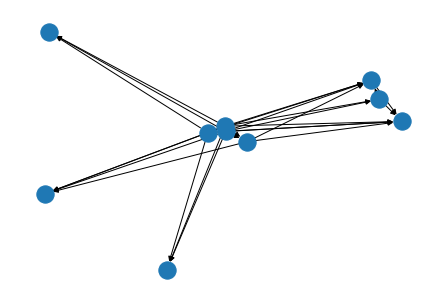

In [79]:
import networkx as nx

data = dataset[idx]
g = tg.utils.to_networkx(data, to_undirected=False)
nx.draw(g)


In [68]:
print(dataset[idx].num_nodes, dataset[idx].num_edges)

10 23


In [69]:
dataset[idx].x.detach().numpy().flatten()

array([ 1.        ,  0.        ,  3.        ,  0.92638436,  1.99022801,
        1.99245868,  0.88      ,  1.        ,  1.        ,  9.        ,
        2.36807095,  1.86622321,  1.03246753,  0.84      ,  1.        ,
        0.        ,  4.        ,  2.51675042,  1.32747069,  3.33244949,
        0.72      ,  1.        ,  0.        ,  6.        ,  2.57185039,
        0.99311024,  1.85656566,  0.6       ,  1.        ,  0.        ,
        0.        ,  1.91632231,  1.38533058,  1.48290043,  0.56      ,
        1.        ,  0.        ,  5.        ,  2.33189655,  1.15086207,
        1.01818182,  0.4       ,  1.        ,  0.        ,  4.        ,
        2.5696649 ,  1.08465608,  2.29356061,  0.32      ,  1.        ,
        0.        ,  2.        ,  2.65363128,  1.12011173,  3.13333333,
        0.2       ,  0.        ,  1.        , 11.        ,  3.37752161,
        1.129683  ,  1.04      ,  0.2       ,  1.        ,  0.        ,
        0.        ,  2.16      ,  0.61333333,  1.        ,  0.04

In [70]:
int(dataset[idx].y.detach().numpy())

0

In [59]:
dataset[idx].edge_index

In [71]:
dataset[idx].edge_index = dataset[0].zeta_index
dataset[idx].num_edges

21

In [63]:


for graph in dataset:
  graph.edge_index = graph.zeta_index
  # is_undir = graph.is_undirected() and is_undir


True


In [72]:
dataset[idx].num_edges

21

In [65]:
# Graph is directed

is_undir = True
for graph in dataset:
  if graph.is_undirected() is False:
    is_undir = False
    break

print(is_undir)

False


In [26]:
# do all graphs have same number of nodes?

is_same_node = True
n_node = dataset[0].num_nodes
for graph in dataset:
  if graph.num_nodes != n_node:
    is_same_node = False
    break

print(is_same_node)


True


## Data preparation for baselines

- concat the node vectors into a longer vector for every graph

In [34]:
import numpy as np

In [73]:
x = dataset[0].x.detach().numpy().flatten()
y = [int(dataset[0].y)]

for i in range(1, len(dataset)):
  x = np.vstack((x, dataset[i].x.detach().numpy().flatten()))
  y.append(int(dataset[i].y))

y = np.array(y)
print(x.shape, y.shape)

(5000, 70) (5000,)


In [74]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Baselines

### Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

In [44]:
clf = LogisticRegression(random_state=42, max_iter=10000).fit(x_train, y_train)
clf.score(x_test, y_test)

0.6853333333333333

### Support Vector Machines

In [45]:
from sklearn import svm

In [46]:
clf = svm.SVC().fit(x_train, y_train)
clf.score(x_test, y_test)

0.6853333333333333

### Artificial Neural Networks

In [47]:
from sklearn.neural_network import MLPClassifier

In [50]:
clf = MLPClassifier(random_state=42, max_iter=100000).fit(x_train, y_train)
clf.score(x_test, y_test)

0.584